We are going to do the project for the Facial Expression Dataset. This is a popular dataset that contains around 7 different emotions with a lot of images. We have 7 classes and you can see the number of files in each class. In the class "disgust" we have less number of files. If we are having less number of files, we can use some class balancing using the Synthetic Minority Oversampling Technique (SMOTE) in order to uniform the class distribution. Other files seen to be well balanced. It's around like 4000. So that is fine for us. We also have a test image or the validation image with the corresponding labels. So we are going to use this dataset for this project. We are going to build a multi-class image classifiaction model with CNN. Now that we have explored the dataset, let's jump into the code!! 

## Import Modules

* <b>pandas</b> - used to perform data manipulation and analysis

* <b>numpy</b> - used to perform a wide variety of mathematical operations on arrays

* <b>matplotlib</b> - used for data visualization and graphical plotting

* <b>seaborn</b> - built on top of matplotlib with similar functionalities

* <b>os</b> - used to handle files using system commands

* <b>tqdm</b> - progress bar decorator for iterators

* <b>warnings</b> - to manipulate warnings details, filterwarnings('ignore') is to ignore the warnings thrown by the modules (gives clean results)

* <b>load_img</b> - used for loading the image as numpy array

* <b>tensorflow</b> – backend module for the use of Keras

* <b>Dense</b> - single dimension linear layer

* <b>Dropout</b> - used to add regularization to the data, avoiding over fitting & dropping out a fraction of the data

* <b>Activation</b> - layer for the use of certain threshold

* <b>Flatten</b> - convert a 2D array into a 1D array

* <b>Conv2D</b> - convolutional layer in 2 dimension

* <b>MaxPooling2D</b> - function to get the maximum pixel value to the next layer



In [95]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

## Load the Dataset

In [96]:
TRAIN_DIR = '../input/facial-expression-dataset/train/train/'
TEST_DIR = '../input/facial-expression-dataset/test/test/'

After this we have to define a function because we have to convert these folders into a complete image path with the corresponding labels. We are going to iterate over the directories. In the directories if we go further, we have the class labels and inside that we will be having the image file names.

In [97]:
def load_dataset(directory):
    image_paths = []
    labels = []
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
        print(label, "Completed")
    return image_paths, labels

This is a function for converting the folder structure into a CSV. Now we will apply this function to get the training dataset. 

In [98]:
# Convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# Shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,../input/facial-expression-dataset/train/train...,sad
1,../input/facial-expression-dataset/train/train...,sad
2,../input/facial-expression-dataset/train/train...,neutral
3,../input/facial-expression-dataset/train/train...,happy
4,../input/facial-expression-dataset/train/train...,sad


We get all the different samples for each label. Now we will apply this function to get the testing dataset. 

In [99]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,../input/facial-expression-dataset/test/test/s...,surprise
1,../input/facial-expression-dataset/test/test/s...,surprise
2,../input/facial-expression-dataset/test/test/s...,surprise
3,../input/facial-expression-dataset/test/test/s...,surprise
4,../input/facial-expression-dataset/test/test/s...,surprise


We are going to use this for the validation purpose. Now the dataset has been loaded successfully. We will now go for exploratory data analysis. 

## Exploratory Data Analysis

<Axes: xlabel='label', ylabel='count'>

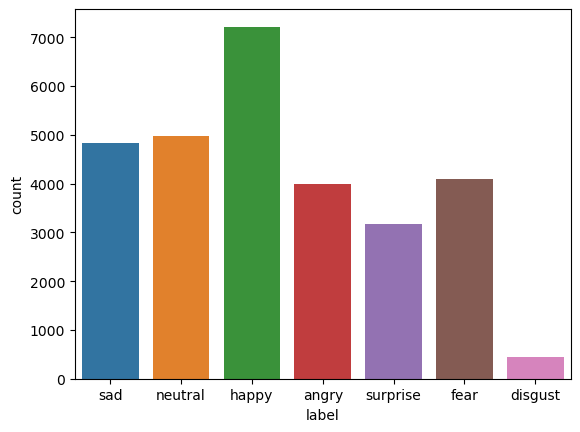

In [100]:
sns.countplot(x = 'label', data = train)

This is the class distribution. The class "happy" has so many labels and otherwise for all the classes the labels are almost equally distributed. Only for the class "disgust" the labels are so less. That means the number of samples for our training data is so less. We may have to use some class balancing like SMOTE methods or Weighted Random Sampler to uniform that. After that we will just load a single image. 

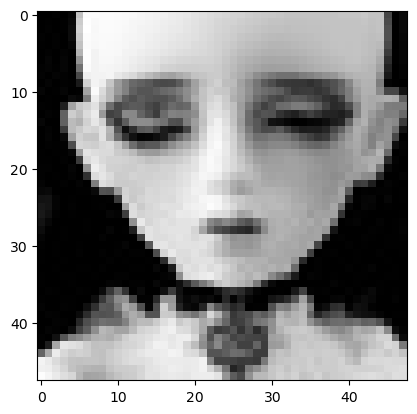

In [101]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

The image is actually in grayscale only so that's why we have to apply this color map. This is the smaple image and you can see the width and height; it is around 48 X 48. So that is the resolution of the image. We are going to dispaly a 5 X 5 matrix of images for the top 25 samples. 

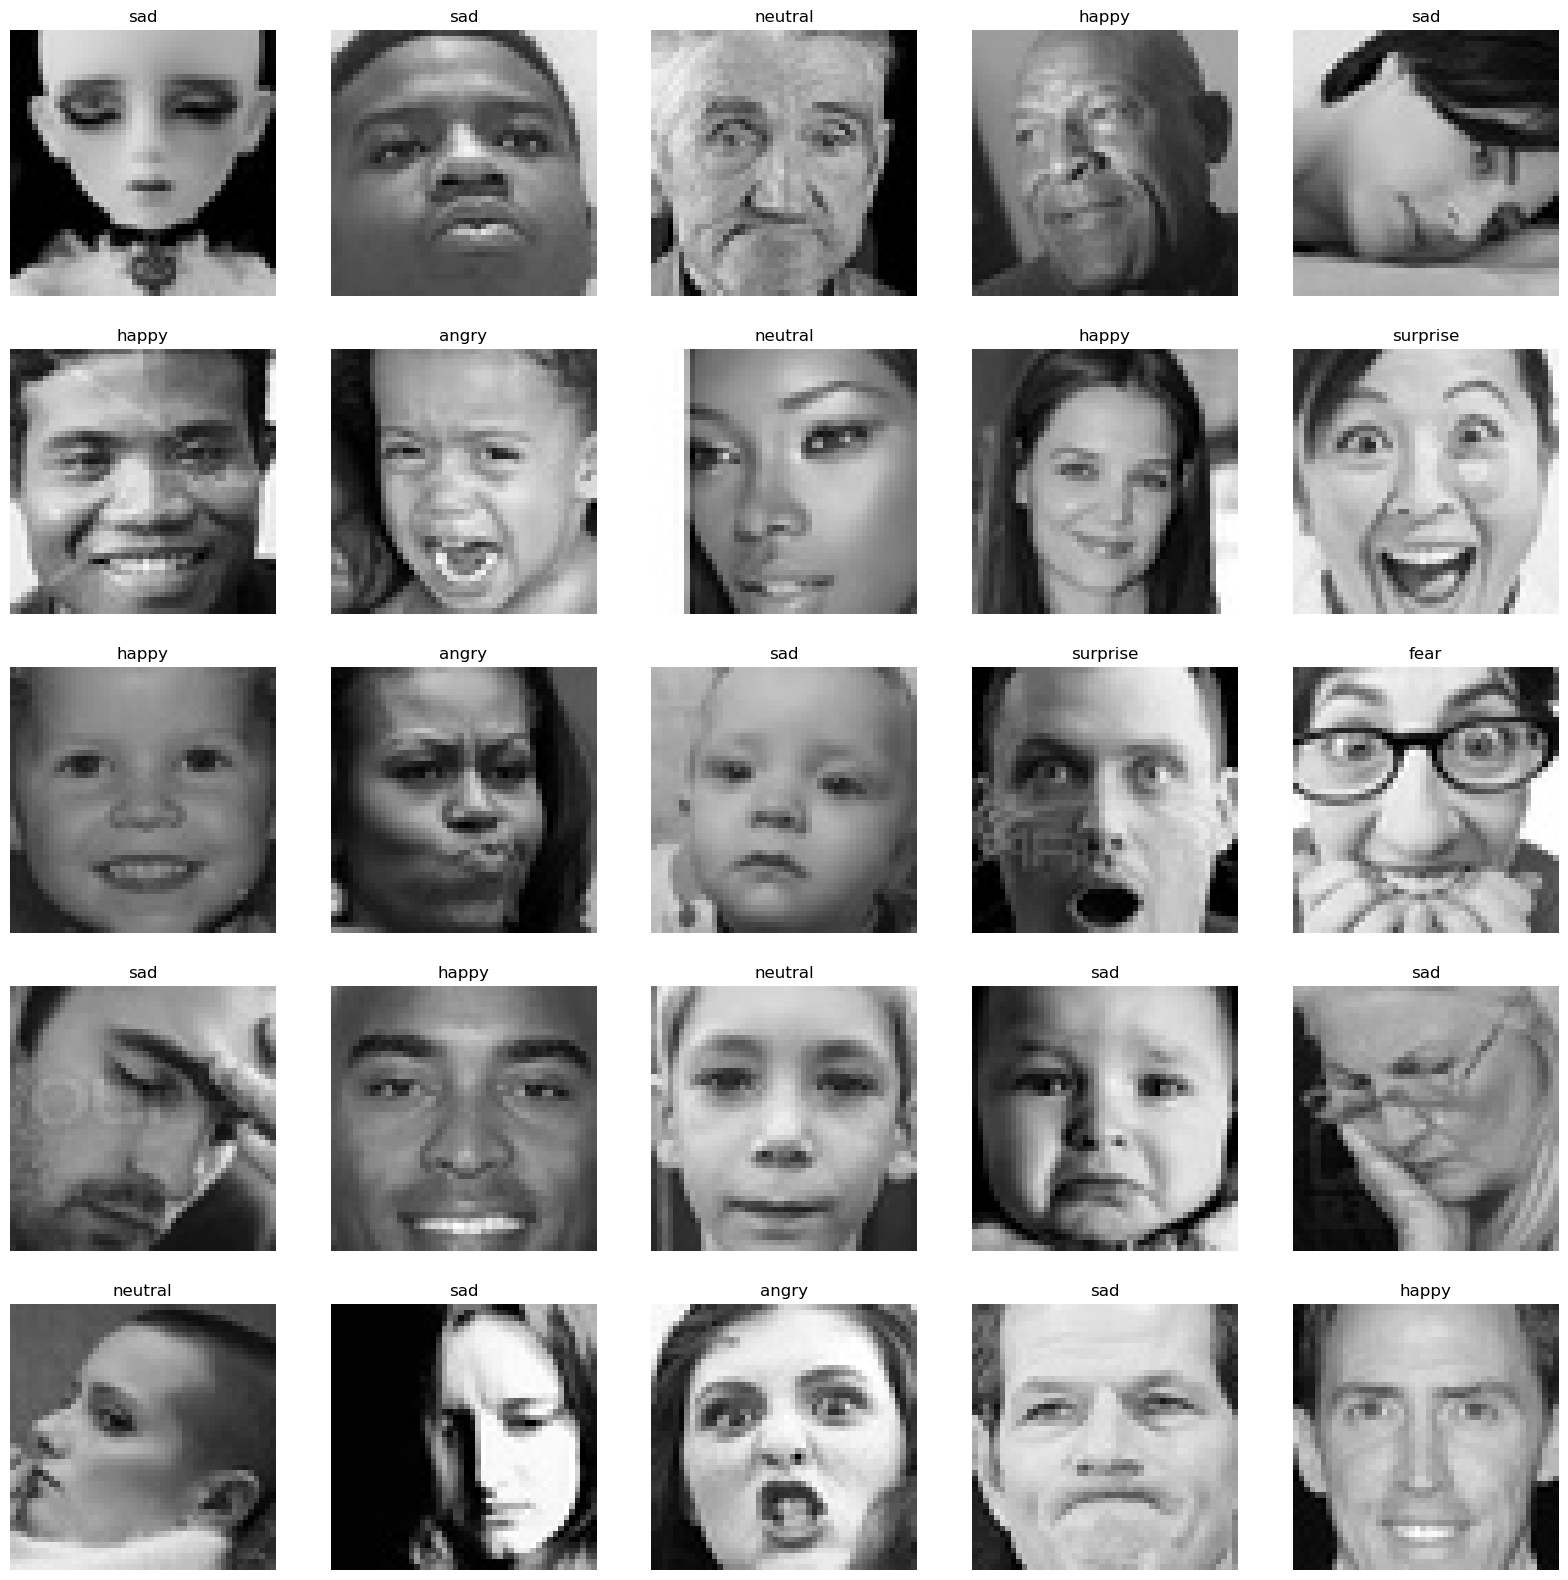

In [102]:
# To display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

After that we have to extract the features of the image. We just have to convert that into a numpy array, load it and reshape it in the proper format. 

## Feature Extraction

In [103]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

Here tqdm creates a loading bar to help track the conversion process of the images. Pixel features of the images are extracted. Images are converted into arrays and reshaped to the proper format. We need to reshape the arrays inorder to feed it into the model. Now we extract the features from both train and test.

In [104]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [105]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

After that we have to normalise the image. This converts the pixel value from 1 to 255 into a normalized range of 0 to 1. Normalization is useful for the neural network to easily capture the information. 

In [106]:
# Normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

We have to do one more preprocessing step that is to convert label to integer for easier processing. Initially the labels for the images are in terms of string in the dataset. We have to convert it into integer. We will be using Label Encoding for that.  

In [107]:
# Convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

Maybe we can convert this Label Encoding into One Hot Encoding because this neural network performs better when we are using One Hot Encoding. 

In [108]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [109]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [110]:
# config
input_shape = (48, 48, 1)
output_class = 7

* <b>input_shape = (48, 48, 1)</b> - Converts the input image into 48 x 48 resolution in grayscale

* <b>output_class</b> = 7 - Total number of classes



## Model Creation

In [111]:
model = Sequential()

# 1st Convolutional Layer (create 1 full layer and reuse the same information)
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))  # Add a dropout layer because we don't want to overfit the dataset

# 2nd Convolutional Layer
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# 3rd Convolutional Layer
model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# 4th Convolutional Layer
model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

We can add Batch normalisation and check whether it it is improving the accuracy or not. Usually we can ignore the dropout layer if we have implemented image augmentation. We are not doing any kind of augmentation here because the images are small so we are just using as it is. 

* <b>optimizer=’adam’</b> - automatically adjust the learning rate for the model over the no. of epochs

* <b>activation='softmax'</b> - used for multi-classification output

* <b>loss=’categorical_crossentropy’</b> - loss function for category outputs

In [112]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100


2023-08-22 22:45:22.679540: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


225/225 [==============================] - 10s 33ms/step - loss: 1.8222 - accuracy: 0.2463 - val_loss: 1.8162 - val_accuracy: 0.2471
Epoch 2/100
225/225 [==============================] - 7s 31ms/step - loss: 1.8056 - accuracy: 0.2515 - val_loss: 1.7945 - val_accuracy: 0.2471
Epoch 3/100
225/225 [==============================] - 7s 31ms/step - loss: 1.7399 - accuracy: 0.2788 - val_loss: 1.6708 - val_accuracy: 0.3075
Epoch 4/100
225/225 [==============================] - 7s 31ms/step - loss: 1.6323 - accuracy: 0.3486 - val_loss: 1.4848 - val_accuracy: 0.4237
Epoch 5/100
225/225 [==============================] - 7s 31ms/step - loss: 1.5196 - accuracy: 0.4093 - val_loss: 1.4005 - val_accuracy: 0.4571
Epoch 6/100
225/225 [==============================] - 7s 32ms/step - loss: 1.4524 - accuracy: 0.4373 - val_loss: 1.3588 - val_accuracy: 0.4801
Epoch 7/100
225/225 [==============================] - 7s 32ms/step - loss: 1.3997 - accuracy: 0.4578 - val_loss: 1.2938 - val_accuracy: 0.4965
Epo

## Plot the Results

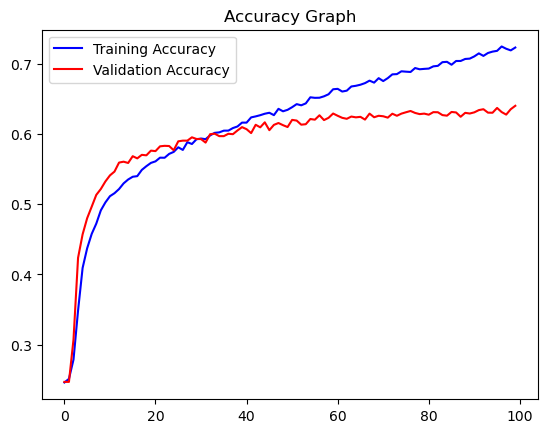

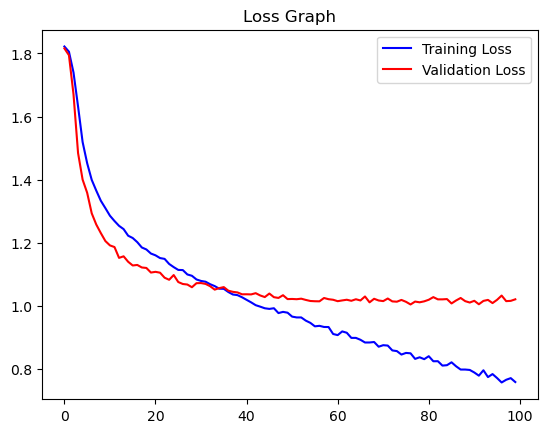

In [113]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Test with Image Data

Now we will display a few random images with its label and predict the output.

Original Output: sad
1/1 [==============================] - 0s 18ms/step
Predicted Output: sad


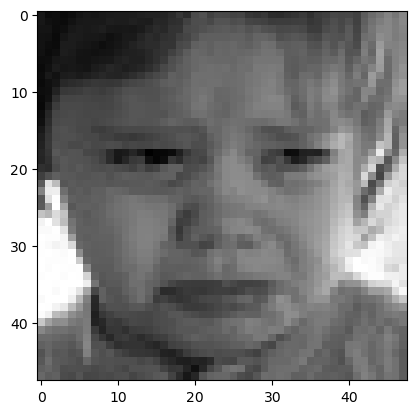

In [127]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: happy
1/1 [==============================] - 0s 34ms/step
Predicted Output: happy


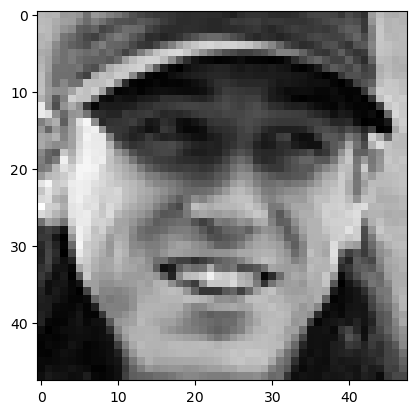

In [121]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: happy
1/1 [==============================] - 0s 18ms/step
Predicted Output: surprise


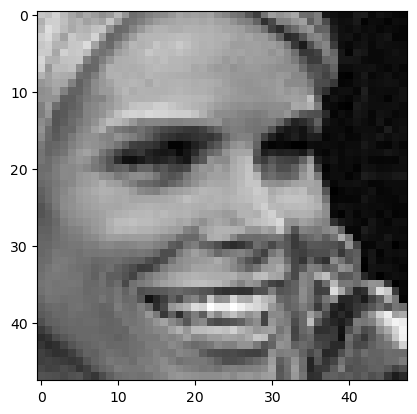

In [131]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Here we see random display of images with original output and predicted output. In some cases the output may differ due to facial expression similarities like fear and surprise. Overall the model predicted very good results. 

## Final Thoughts

* Training the model by increasing the no. of epochs can give better and more accurate results.

* Processing large amount of data can take a lot of time and system resources.

* Basic deep learning model trained in a neural network, adding new layers varies the results.

